In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle

from config import config
from tensorneat.algorithm.hyperneat import FullSubstrate

from substrate_generation.pca_coor_generator import PCAanalyzer
from substrate_generation.pca_inv_coor_generator import InvPCAanalyzer
from substrate_generation.sdl_coor_generator import SparseDictionaryAnalyzer
from substrate_generation.fa_coor_generator import FactorAnalyzer
from substrate_generation.manual_coor_generator import ManualInputMapper
from substrate_generation.hidden_layers import HiddenLayerGenerator
from utils.visualization import display_plots_side_by_side
from utils.utils import save_coordinates_to_csv, setup_folder_structure
from evol_pipeline.brax_env import CustomBraxEnv

A quick setup of the folder structure to avoid errors further down the line.

In [2]:
OUTPUT_DIR = config["experiment"]["output_dir"]
setup_folder_structure(OUTPUT_DIR)

with open(f"{OUTPUT_DIR}/data_sources.pkl", "rb") as f:
    data_sources = pickle.load(f)

env_name = config["experiment"]["env_name"]
env_problem = CustomBraxEnv(
    env_name=env_name,
    backend=config["environment"]["backend"],
    brax_args=config["environment"]["brax_args"],
    max_step=config["environment"]["max_step"],
    repeat_times=config["environment"]["repeat_times"],
    obs_normalization=False,
    sample_episodes=16,
)
obs_size = env_problem.input_shape[0]
act_size = env_problem.output_shape[0]

/home/andi/anaconda3/envs/jax/lib/python3.10/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(
2025-09-07 21:56:26.653664: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-09-07 21:56:37.795433: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by usin

### Setup Environment

[Brax environments](https://github.com/google/brax/tree/main/brax/envs) are used for this experiment through the [TensorNEAT wrapper](https://github.com/EMI-Group/tensorneat/tree/main/src/tensorneat/problem/rl).

## Data Analysis

Next, it's time to analyse the sampled data. The goal is to find correlations in the data which can be used to assign substrate coordinates. Again, different methods are used for comparison, namely Principal Component Analysis (PCA), Factor Analysis (FA) and Sparse Dictionary Learning (SDL). These methods will be applied to both data samples.

In this first step, the analysis methods will be used to produce input and output coordinates only. The hidden_layers are later generated.

In [3]:
analysis_io_coors = defaultdict(lambda: defaultdict(dict))

### PCA Analysis

Principal Component Analysis (PCA) is commonly used for dimensionality reduction and using Singular Value Decomposition of the data to project it to a lower dimensional space. The [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) of PCA is used here.

Analyzing trained sampling data with PCA
Running PCA to find feature dimensions covering 70.0% of variance (with a hard limit of 6 dimensions)...
PCA found 5 dimensions needed for 70.0% variance.
Applying max limit. Final number of feature dimensions: 5
Added layering dimension. Final coordinate size: 6
PCA variance plot saved to: output/ant/data_analysis/pca_variance_70_trained.png
Principal component heatmap saved to: output/ant/data_analysis/pca_heatmap_70_trained.png


Analyzing trained sampling data with PCA
Running PCA to find feature dimensions covering 99.0% of variance (with a hard limit of 6 dimensions)...
PCA found 15 dimensions needed for 99.0% variance.
Applying max limit. Final number of feature dimensions: 6
Added layering dimension. Final coordinate size: 7
PCA variance plot saved to: output/ant/data_analysis/pca_variance_99_trained.png
Principal component heatmap saved to: output/ant/data_analysis/pca_heatmap_99_trained.png


Analyzing random sampling data with PCA
Run

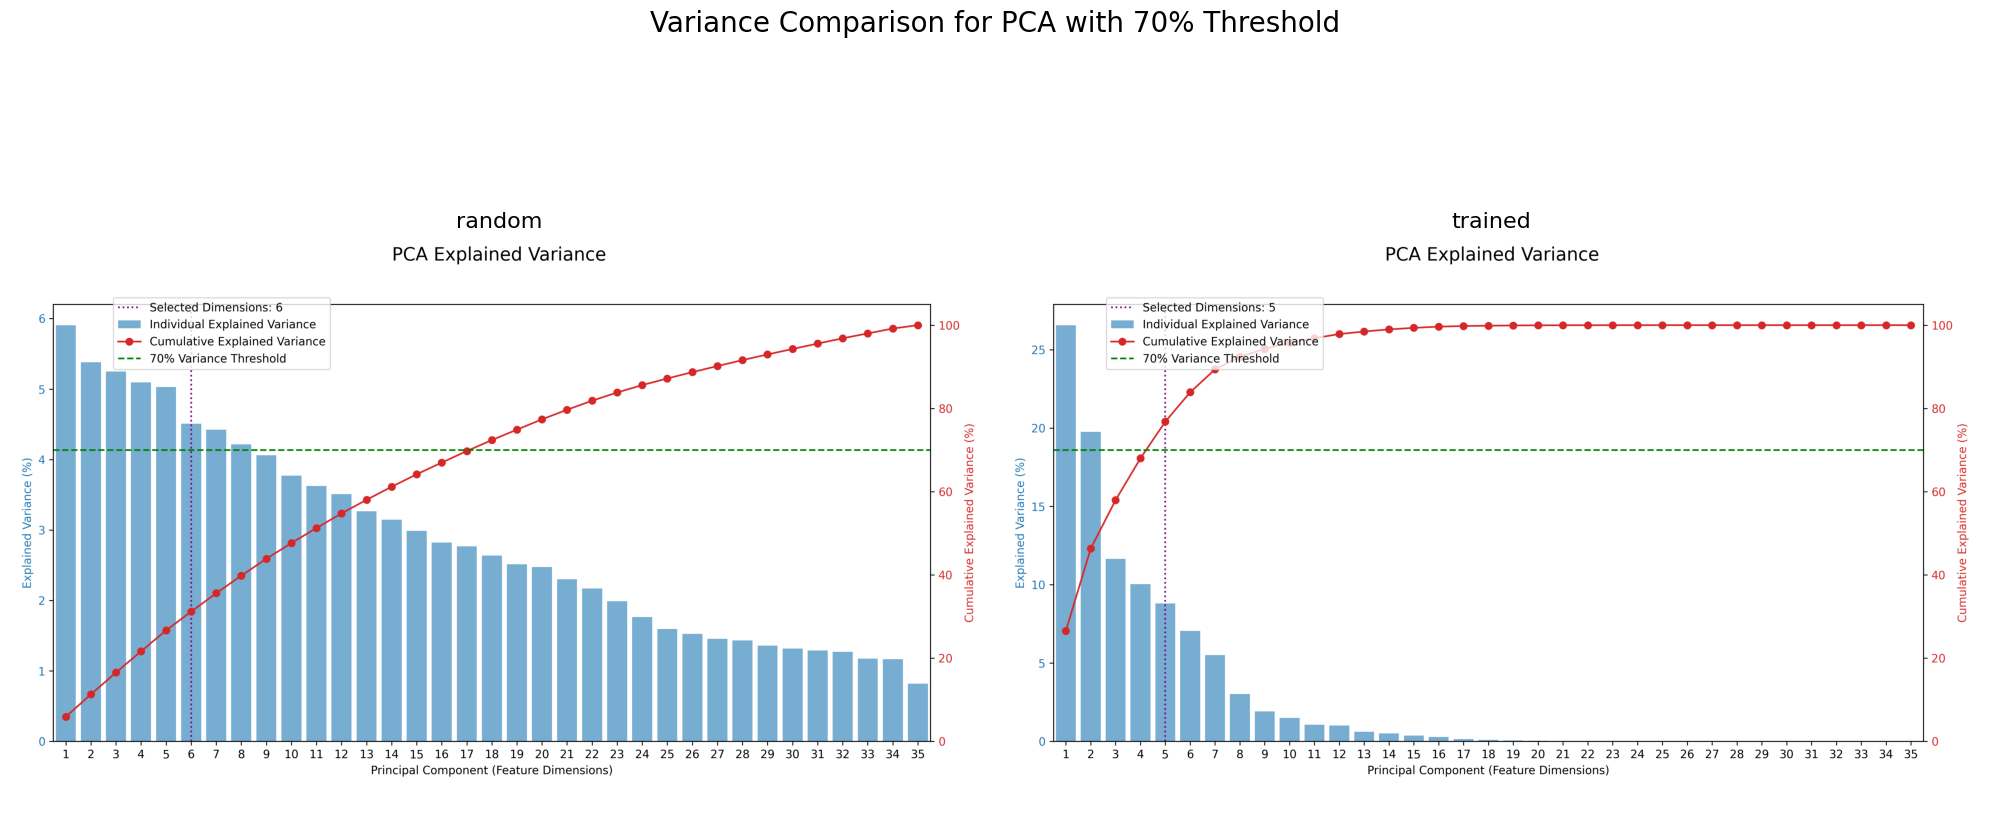

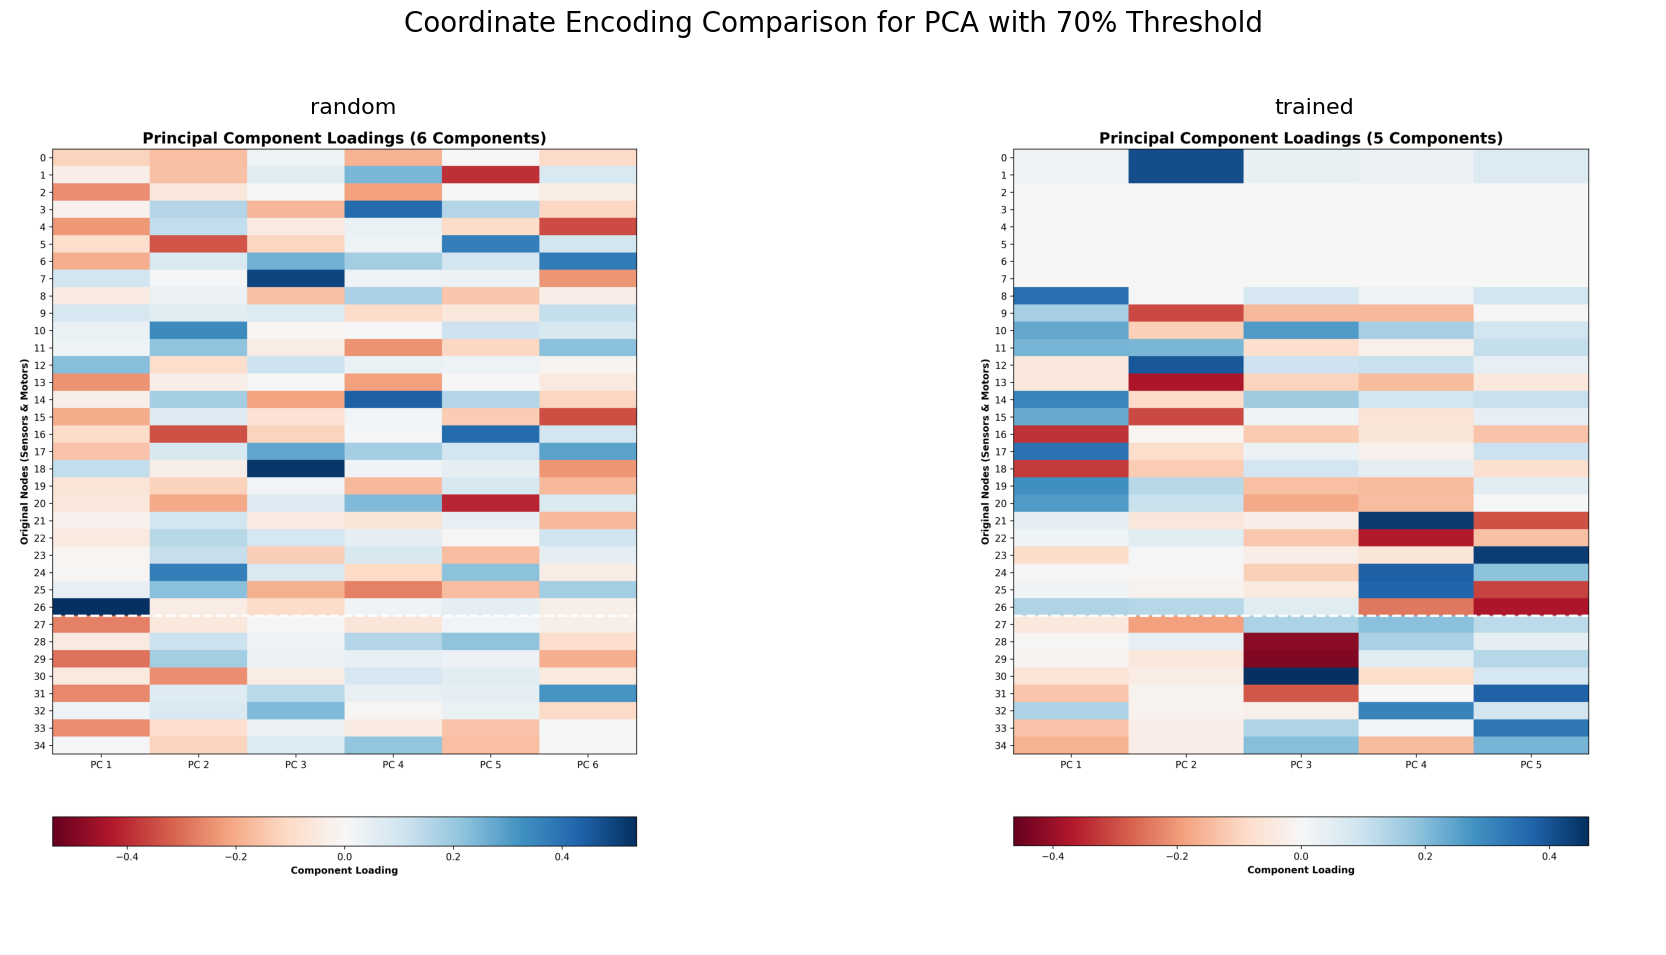

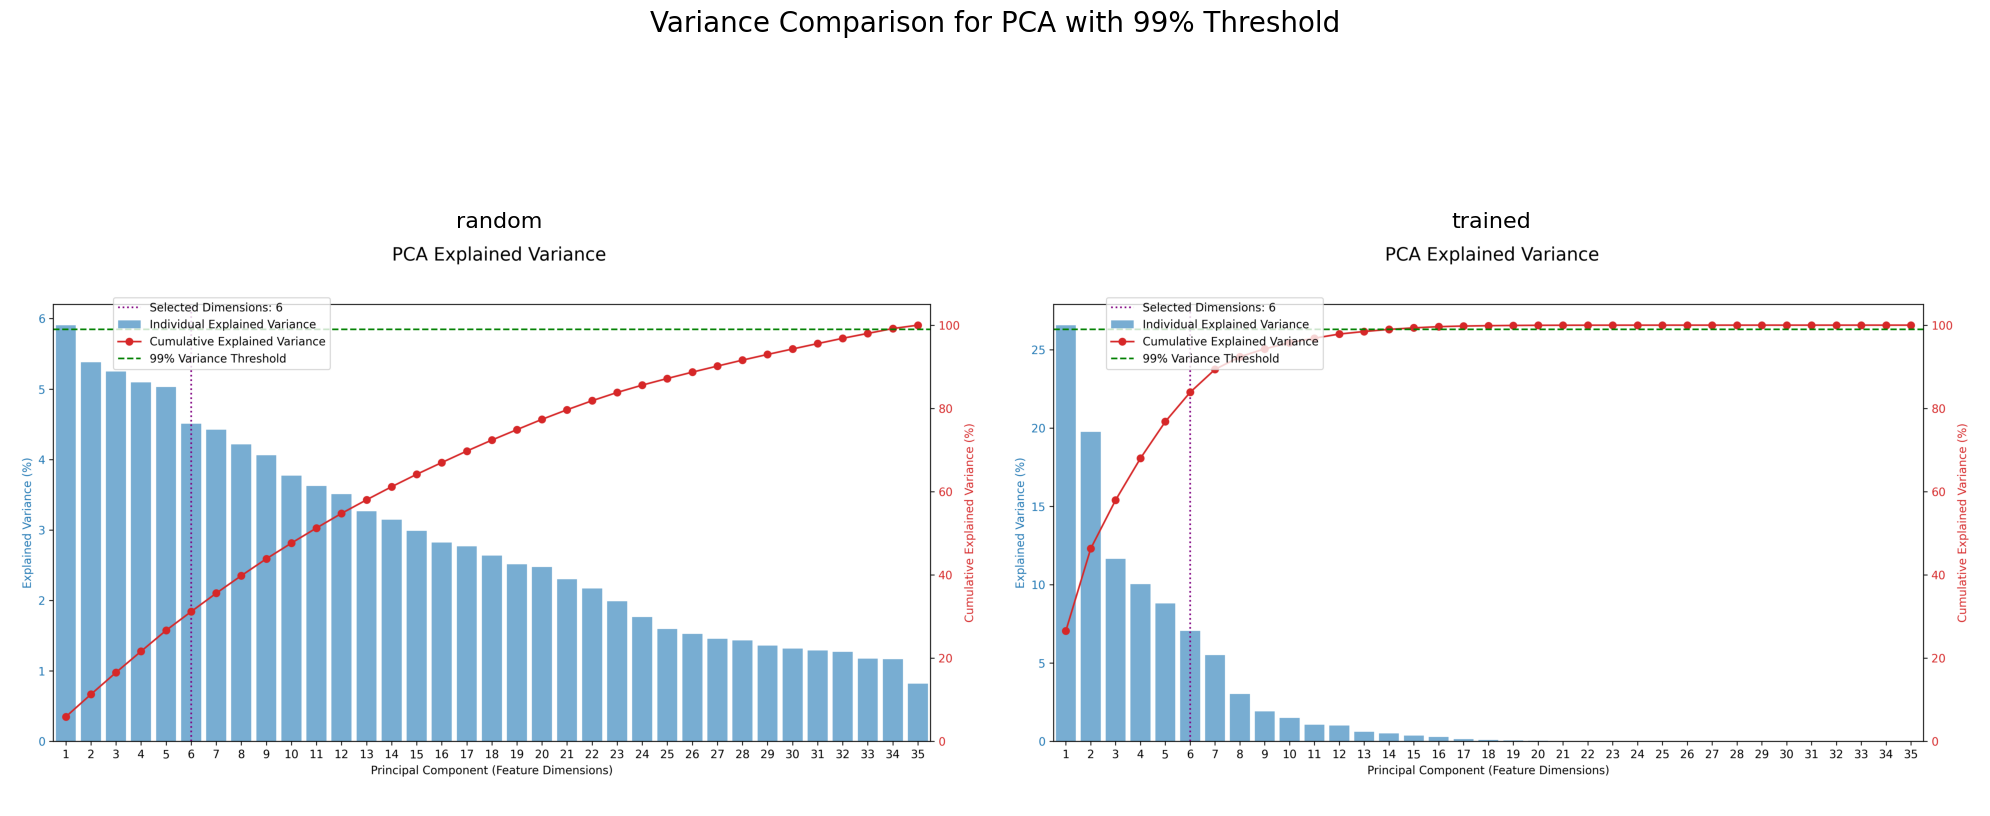

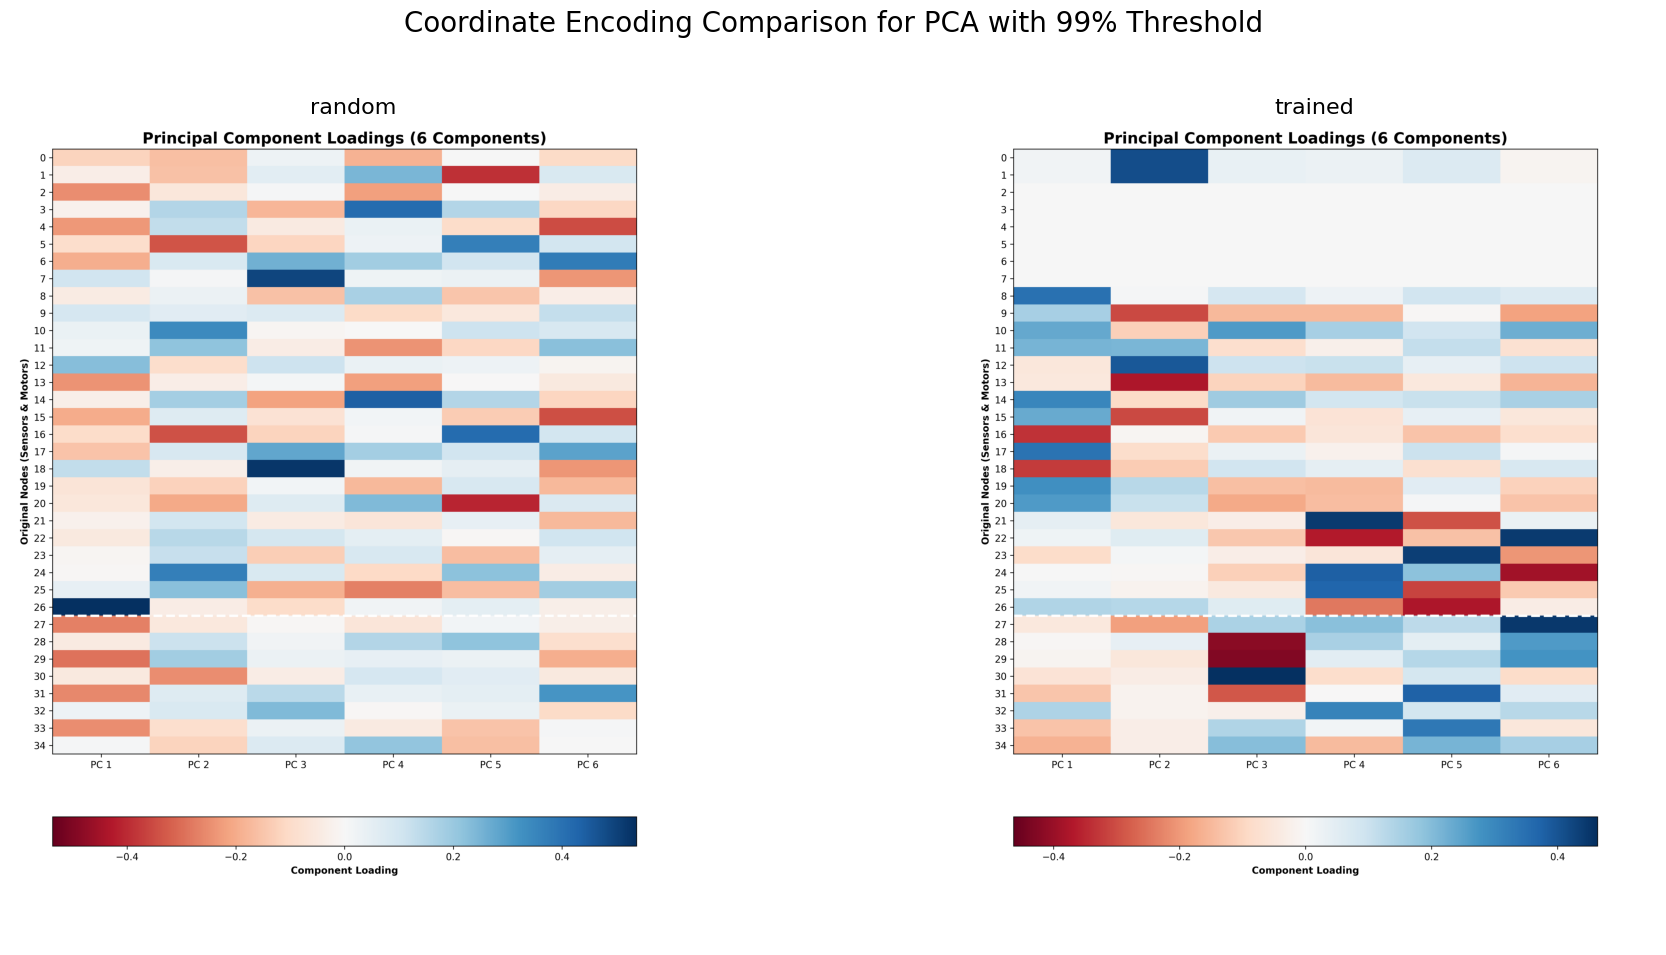

In [4]:
pca_variances = [config["data_analysis"]["variance_threshold"], 0.99]

for data_label, data_array in data_sources.items():
    for variance in pca_variances:
        percentage = int(variance*100)
        print(f"Analyzing {data_label} sampling data with PCA")
        analyzer_pca = PCAanalyzer(
            data=data_array, 
            obs_size=obs_size, 
            act_size=act_size,
            variance_threshold=variance, 
            max_dims=config["data_analysis"]["max_dims"](obs_size),
            hidden_depth=config["substrate"]["hidden_depth"]
        )
        input_coors, output_coors = analyzer_pca.generate_io_coordinates()
        analysis_io_coors[data_label][f"pca{percentage}"]["input_coors"] = input_coors
        analysis_io_coors[data_label][f"pca{percentage}"]["output_coors"] = output_coors
        analyzer_pca.plot_variance(save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_{data_label}.png")
        analyzer_pca.plot_principal_components(save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_{data_label}.png")
        print("\n")

for variance in pca_variances:
    percentage = int(variance*100)
    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_random.png", f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_trained.png"],
        plot_titles=["random", "trained"],
        main_title=f"Variance Comparison for PCA with {percentage}% Threshold",
        save_path=f"{OUTPUT_DIR}/data_analysis/pca_variance_{percentage}_comparison.png"
    )
    display_plots_side_by_side(
        plot_paths=[f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_random.png", f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_trained.png"],
        plot_titles=["random", "trained"],
        main_title=f"Coordinate Encoding Comparison for PCA with {percentage}% Threshold",
        save_path=f"{OUTPUT_DIR}/data_analysis/pca_heatmap_{percentage}_comparison.png"
    )

For comparison another alternative substrate is builded from the PCAs covering the least variance.

Analyzing trained sampling data with PCA
Running inverse PCA to find 6 feature dimensions covering least variance...
Found PCs with minimum variance and added layering dimension. Final coordinate size: 7
Inverse PCA variance plot saved to: output/ant/data_analysis/inv_pca_trained.png
Principal component heatmap saved to: output/ant/data_analysis/inv_pca_heatmap_trained.png


Analyzing random sampling data with PCA
Running inverse PCA to find 6 feature dimensions covering least variance...
Found PCs with minimum variance and added layering dimension. Final coordinate size: 7
Inverse PCA variance plot saved to: output/ant/data_analysis/inv_pca_random.png
Principal component heatmap saved to: output/ant/data_analysis/inv_pca_heatmap_random.png




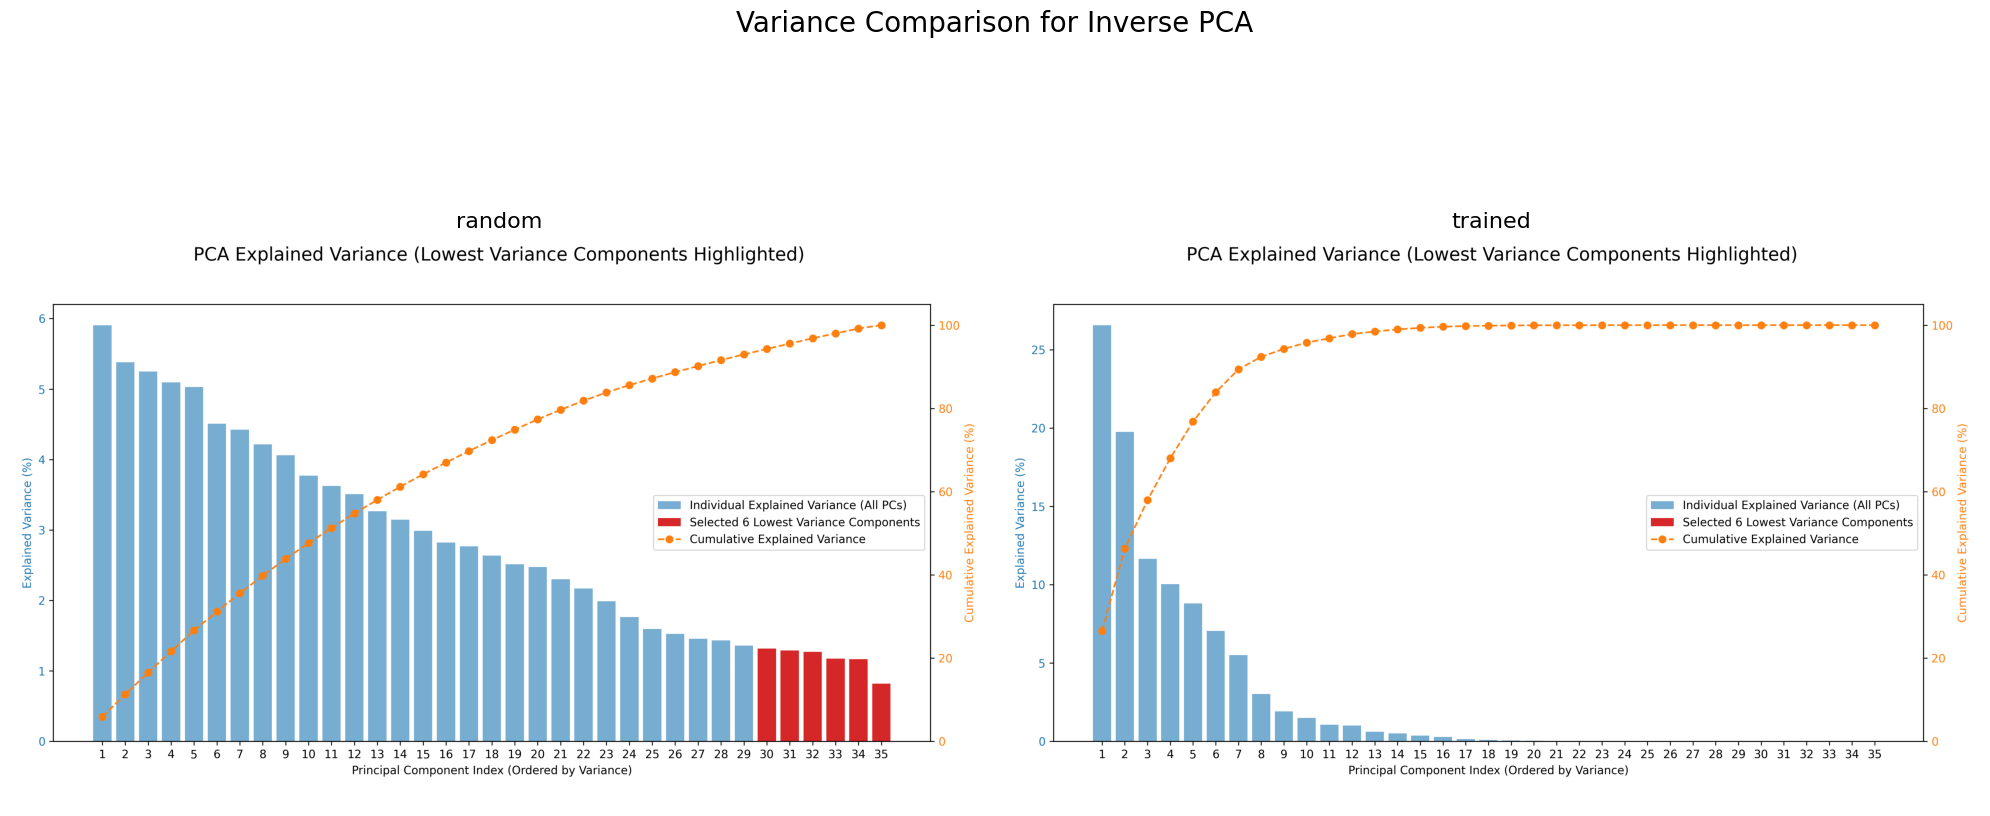

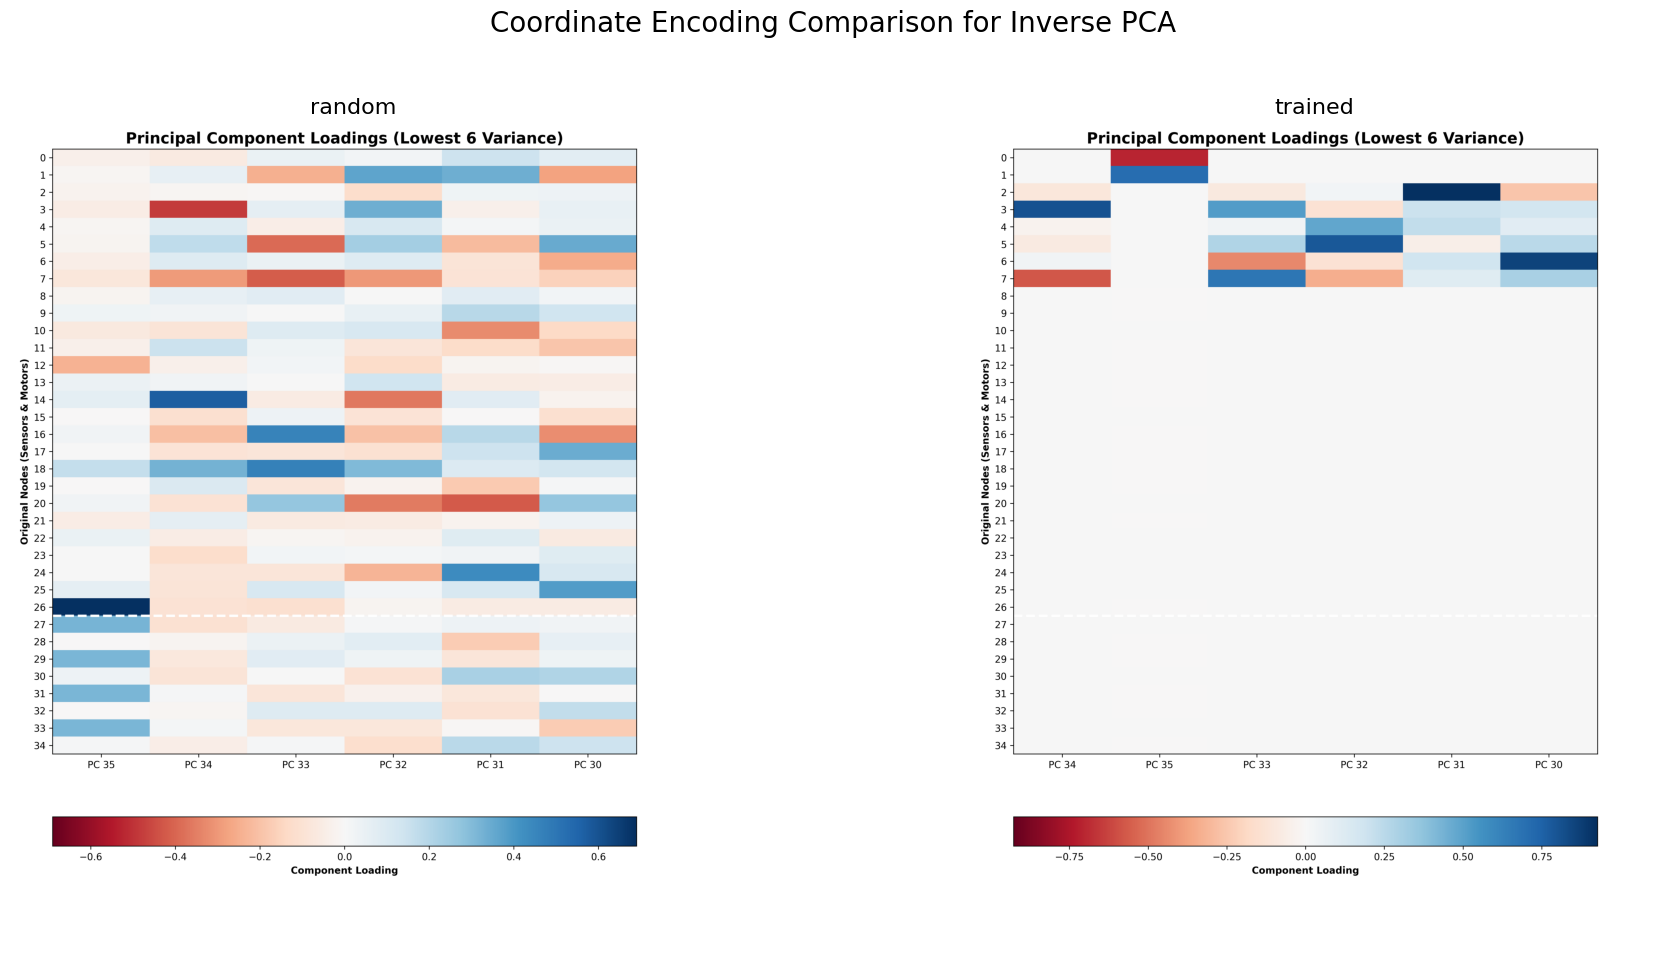

In [5]:
for data_label, data_array in data_sources.items():
    percentage = int(variance*100)
    print(f"Analyzing {data_label} sampling data with PCA")
    analyzer_inv_pca = InvPCAanalyzer(
        data=data_array, 
        obs_size=obs_size, 
        act_size=act_size,
        max_dims=config["data_analysis"]["max_dims"](obs_size),
        hidden_depth=config["substrate"]["hidden_depth"]
    )
    input_coors, output_coors = analyzer_inv_pca.generate_io_coordinates()
    analysis_io_coors[data_label][f"inv_pca_"]["input_coors"] = input_coors
    analysis_io_coors[data_label][f"inv_pca_"]["output_coors"] = output_coors
    analyzer_inv_pca.plot_least_variance_components(save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_{data_label}.png")
    analyzer_inv_pca.plot_principal_components(save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_{data_label}.png")
    print("\n")

percentage = int(variance*100)
display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/inv_pca_random.png", f"{OUTPUT_DIR}/data_analysis/inv_pca_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Variance Comparison for Inverse PCA",
    save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_variance_comparison.png"
)
display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Coordinate Encoding Comparison for Inverse PCA",
    save_path=f"{OUTPUT_DIR}/data_analysis/inv_pca_heatmap_comparison.png"
)

### Factor Analysis

Next, the data is analysed through factor analysis.

Analyzing trained sampling data
Running Factor Analysis to find 6 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Added layering dimension. Final coordinate size: 7
Running Factor Analysis to find 6 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Added layering dimension. Final coordinate size: 7
Factor loadings heatmap saved to: output/ant/data_analysis/fa_heatmap_trained.png


Analyzing random sampling data
Running Factor Analysis to find 6 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Added layering dimension. Final coordinate size: 7
Running Factor Analysis to find 6 latent factors...
Factor Analysis complete. Extracting coordinates (factor loadings).
Added layering dimension. Final coordinate size: 7
Factor loadings heatmap saved to: output/ant/data_analysis/fa_heatmap_random.png




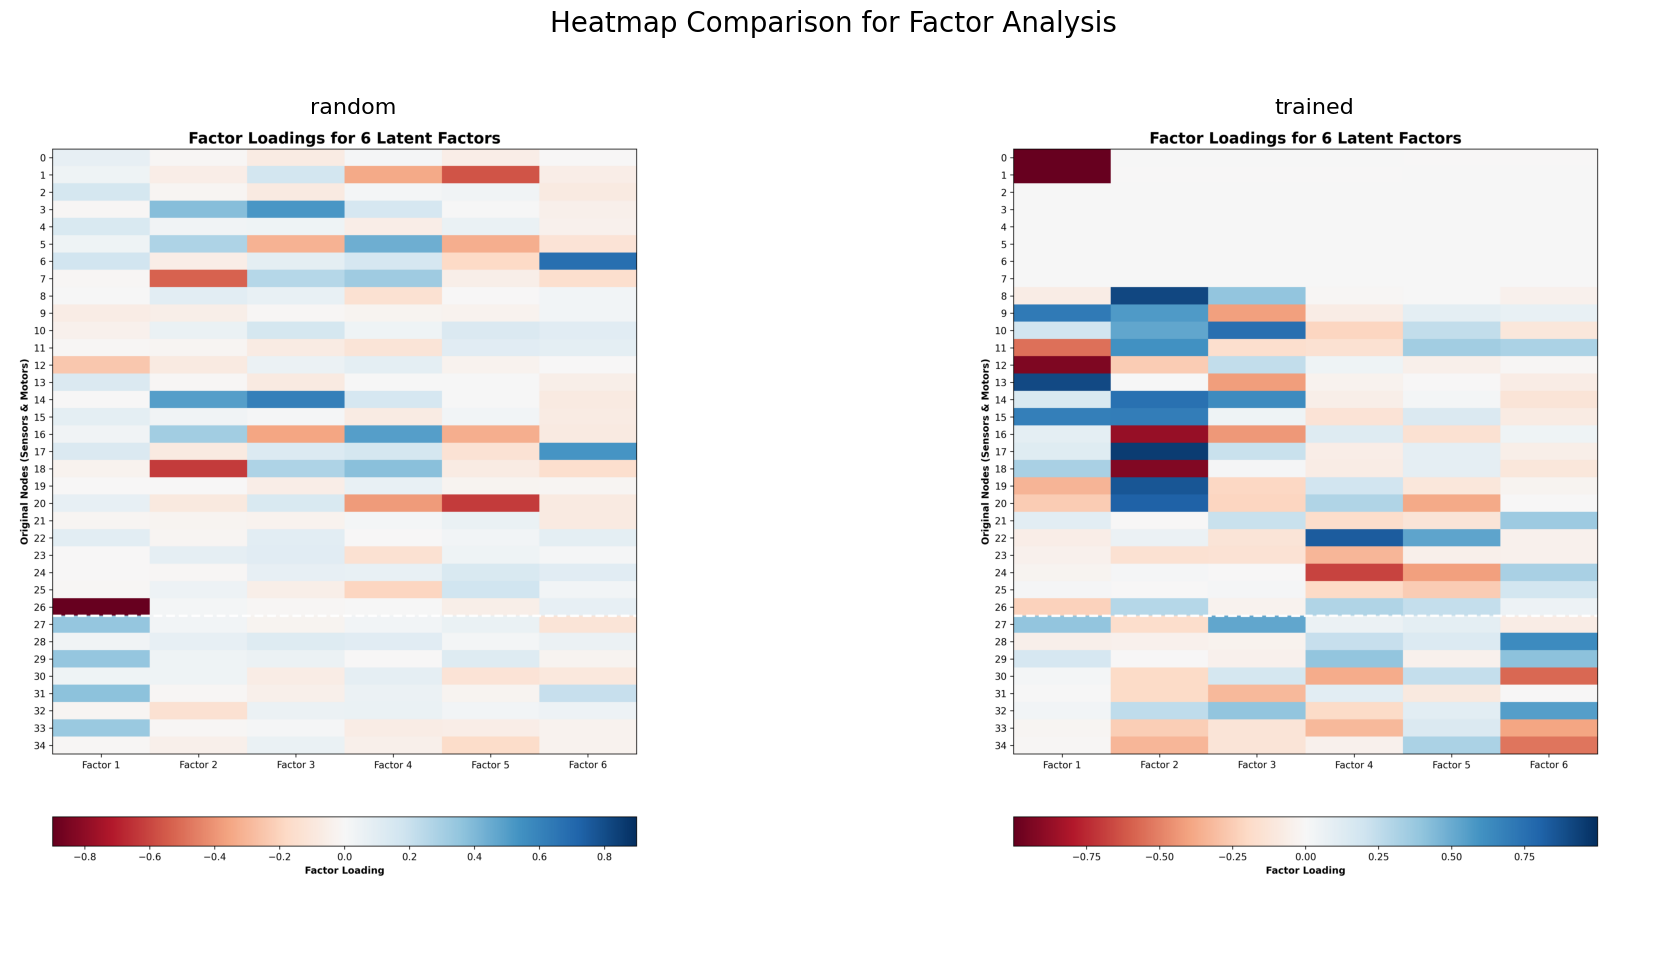

In [6]:
for data_label, data_array in data_sources.items():
    print(f"Analyzing {data_label} sampling data")
    analyzer_fa = FactorAnalyzer(
        data=data_array, 
        obs_size=obs_size, 
        act_size=act_size,
        max_dims=config["data_analysis"]["max_dims"](obs_size),
        hidden_depth=config["substrate"]["hidden_depth"]
    )
    input_coors, output_coors = analyzer_fa.generate_io_coordinates()
    analysis_io_coors[data_label]["fa"]["input_coors"] = input_coors
    analysis_io_coors[data_label]["fa"]["output_coors"] = output_coors
    input_coors_fa, output_coors_fa = analyzer_fa.generate_io_coordinates()
    analyzer_fa.plot_factor_loadings(save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap_{data_label}.png")
    print("\n")

display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/fa_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/fa_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Heatmap Comparison for Factor Analysis",
    save_path=f"{OUTPUT_DIR}/data_analysis/fa_heatmap_comparison.png"
)

### Sparse Dictionary Learning

Lastly, Sparse Dictionary Learning is also applied to the data.

Analyzing trained sampling data
Running Sparse Dictionary Learning to find 6 dictionary atoms...
SDL complete. Extracting coordinates (loadings on dictionary atoms).
Added layering dimension. Final coordinate size: 7
Dictionary atoms heatmap saved to: output/ant/data_analysis/sdl_heatmap_trained.png


Analyzing random sampling data
Running Sparse Dictionary Learning to find 6 dictionary atoms...
SDL complete. Extracting coordinates (loadings on dictionary atoms).
Added layering dimension. Final coordinate size: 7
Dictionary atoms heatmap saved to: output/ant/data_analysis/sdl_heatmap_random.png




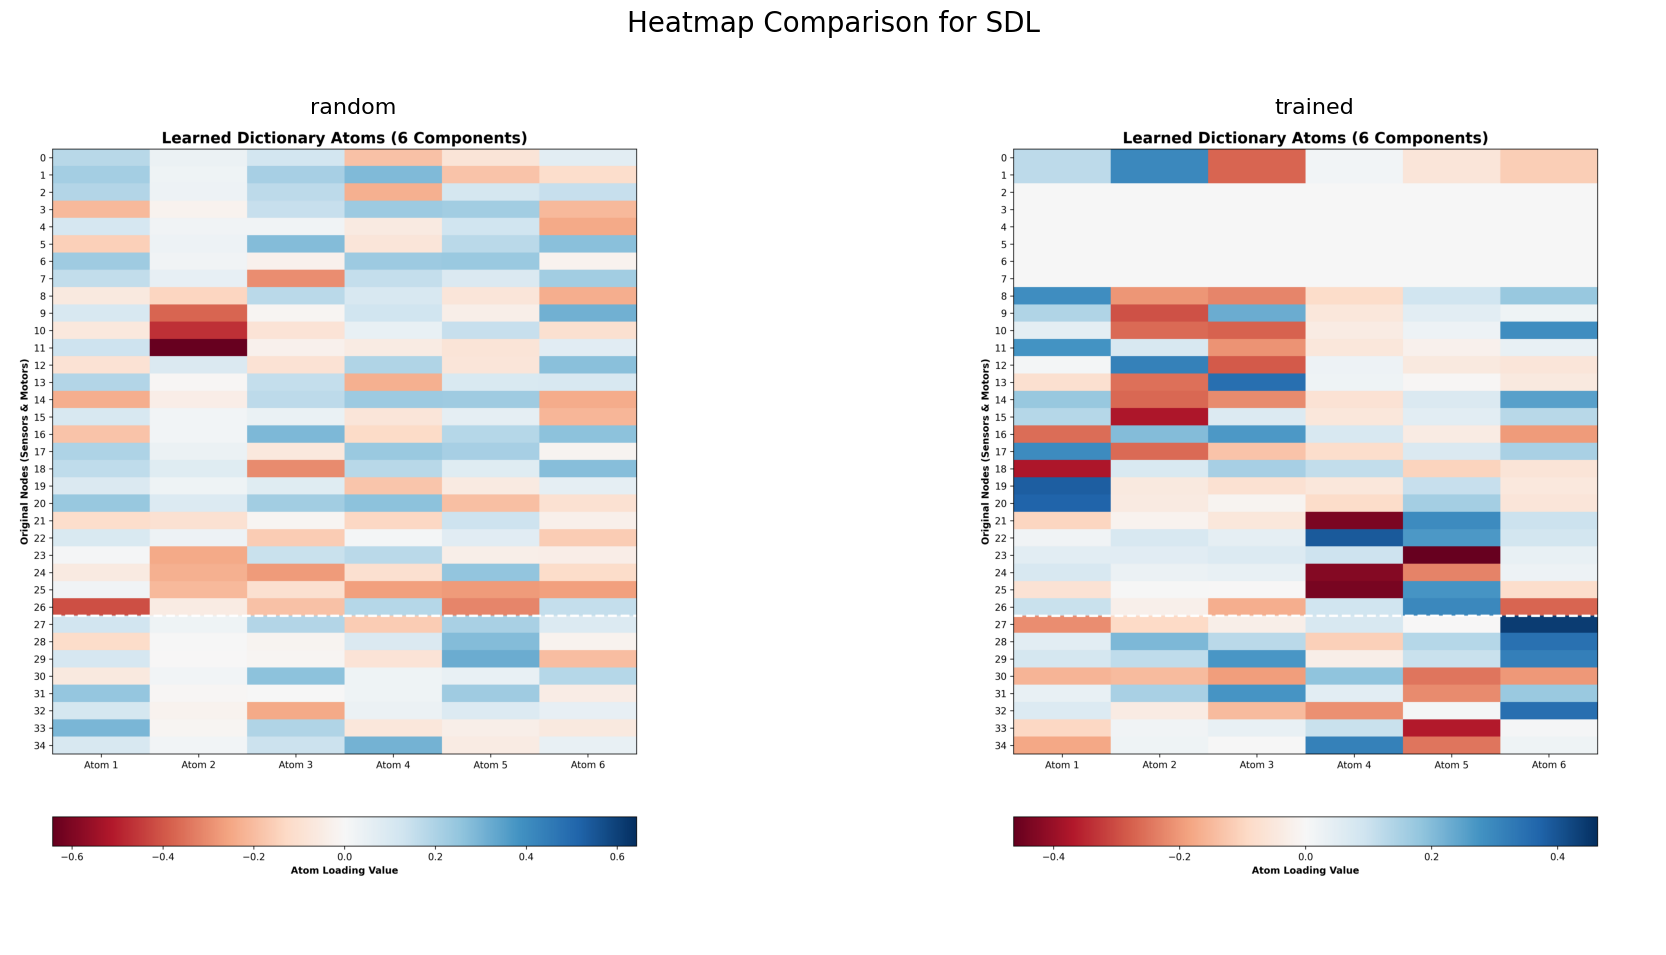

In [7]:
for data_label, data_array in data_sources.items():
    print(f"Analyzing {data_label} sampling data")
    analyzer_sdl = SparseDictionaryAnalyzer(
        data=data_array,
        obs_size=obs_size,
        act_size=act_size,
        max_dims=config["data_analysis"]["max_dims"](obs_size),
        alpha=config["data_analysis"]["sdl_alpha"],
        max_iter=config["data_analysis"]["sdl_max_iter"],
        hidden_depth=config["substrate"]["hidden_depth"]
    )
    input_coors_sdl, output_coors_sdl = analyzer_sdl.generate_io_coordinates()
    analysis_io_coors[data_label]["sdl"]["input_coors"] = input_coors
    analysis_io_coors[data_label]["sdl"]["output_coors"] = output_coors
    analyzer_sdl.plot_dictionary_atoms(save_path=f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_{data_label}.png")
    print("\n")

display_plots_side_by_side(
    plot_paths=[f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_random.png", f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_trained.png"],
    plot_titles=["random", "trained"],
    main_title=f"Heatmap Comparison for SDL",
    save_path=f"{OUTPUT_DIR}/data_analysis/sdl_heatmap_comparison.png"
)

## Substrate Generation

Now it's time to generate the full substrates. The input and ouput nodes have already been generated above, so the hidden layers are the crucial part that's missing.

### Generating Hidden Layers

A `HiddenLayerGenerator` class is used to generate hidden nodes from the input node. There are of course, many ways these hidden nodes can be defined in the high-dimensional space. The class has a few options hard-coded:

* `one_hot`: This does a one-hot encoding of the dimensions, so there will be one coordinate for each dimension. E.g. for 3 Dimensions: (1,0,0),(0,1,0),(0,0,1)
* `one_double_hot`: This is the same as one-hot, but has two coordinates in every dimension, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(2,0,0),(0,2,0),(0,0,2)
* `two_hot`: This adds all possible pairs of dimensions as coordinates to the one_hor ecoding, e.g. for 3 dimensions: (1,0,0),(0,1,0),(0,0,1),(1,1,0),(1,0,1),(0,1,1)
* `shift`: This schema takes all input nodes and simply "shifts" every one of them into the layering direction by 1 for each layer.

One important thing to notice is that the number of generated hidden nodes is highly dependent on the number of dimensions (one_hot/one_double_hot linear and two_hot exponential), except for the `shift` method.

In [8]:
hidden_layer_gen = HiddenLayerGenerator(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    hidden_depth=config["substrate"]["hidden_depth"],
)

substrates = defaultdict(lambda: defaultdict(dict))

### Simple Baseline Substrates

Before the data-driven approchaes are applied, some baselines are needed. The first one is a very simple 2D grid. This is the basic baseline in the sense of a "vanilla" HyperNEAT algorithm.

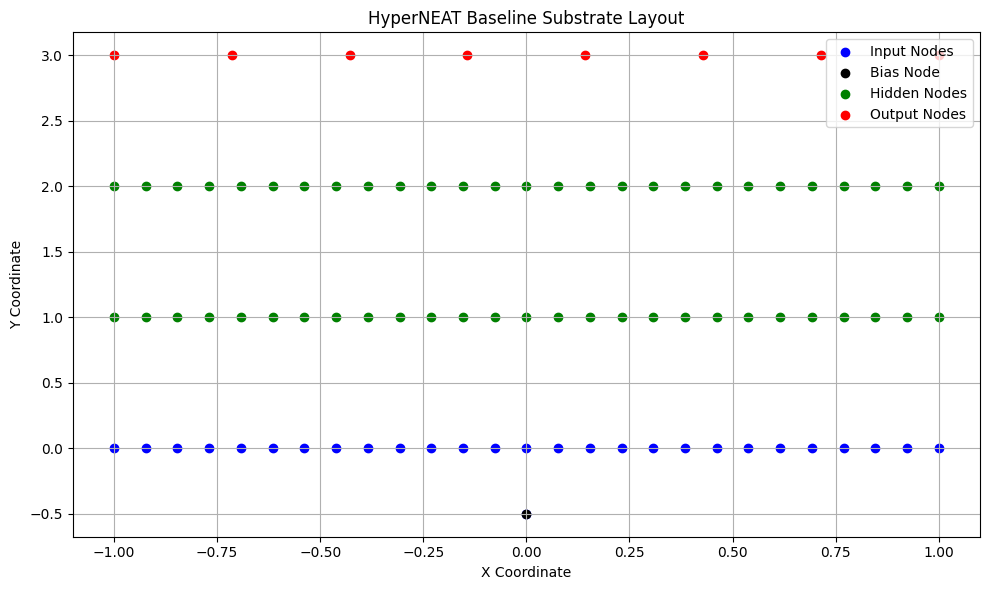

In [9]:
hidden_width = obs_size
hidden_depth = config["substrate"]["hidden_depth"]

# Input neurons spaced horizontally from -1 to 1 at y = 0
input_coors_simple_wo_bias = [(i / (obs_size - 1) * 2 - 1, 0) for i in range(obs_size)]

# Bias node placed slightly below input layer for distinctiveness
bias_coor_simple = [(0, -0.5)]

# Hidden neurons spaced out evenly between input and output
hidden_coors_simple = [
    ((i / (hidden_width - 1) * 2 - 1), (j / max(1,(hidden_depth - 1)) * (hidden_depth - 1) + 1.0))
    for j in range(hidden_depth)
    for i in range(hidden_width)
]

# Output neurons spaced out evenly horizontally above (y =+ 1) hidden neurons
output_coors_simple = [(i / (act_size - 1) * 2 - 1, (hidden_depth+1)) for i in range(act_size)]

input_coors_simple = input_coors_simple_wo_bias + bias_coor_simple

substrates["manual"]["simple"]["substrate"] = FullSubstrate(
    input_coors=input_coors_simple,
    hidden_coors=hidden_coors_simple,
    output_coors=output_coors_simple,
)

substrates["manual"]["simple"]["input_coors"] = input_coors_simple
substrates["manual"]["simple"]["hidden_coors"] = hidden_coors_simple
substrates["manual"]["simple"]["output_coors"] = output_coors_simple

plt.figure(figsize=(10, 6))

# Plot each layer with different colors
x, y = zip(*input_coors_simple)
plt.scatter(x, y, c='blue', label='Input Nodes')
x, y = zip(*bias_coor_simple)
plt.scatter(x, y, c='black', label='Bias Node')
x, y = zip(*hidden_coors_simple)
plt.scatter(x, y, c='green', label='Hidden Nodes')
x, y = zip(*output_coors_simple)
plt.scatter(x, y, c='red', label='Output Nodes')

plt.title('HyperNEAT Baseline Substrate Layout')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/baseline_substrate")
plt.show()

### Substrate from Manual Mapping

The next baseline represents a substrate which is "hand-crafted" by a human expert.

A `ManualInputMapper` class creates substrate coordinates from a mapping of semantically meaningful categories such as "front", "back", "velocity", "angle". Every substrate node can be sorted into multiple categories. One of multiple categories form a dimension. E.g. "angle" might be a single dimension on its own whereas "front" and "back" are two opposite directions in the same dimension. Accordingly every category maps to a vector in the respective dimension. Applying all the vectors for a node, e.g. "front", "left", "hip" and "angular velocity" for the input node "angular velocity of the front left hip", generates the coordinate (0, 0, 1, 0, 0, 0, 0, -1, 1, 1, 0, 0).

The manual mappings are are implemented for the following [Brax environments](https://github.com/google/brax/tree/main/brax/envs):
* ant
* halfcheetah
* swimmer

In [10]:
manual_mapper = ManualInputMapper(
    env_name=env_name,
    obs_size=obs_size,
    act_size=act_size,
    hidden_layer_type=config["substrate"]["hidden_layer_type"],
    hidden_depth=config["substrate"]["hidden_depth"],
)
input_coors_manual, output_coors_manual = manual_mapper.generate_io_coordinates()
hidden_coors_manual = hidden_layer_gen.get_hidden_coors(input_coors=input_coors_manual)

substrates["manual"]["mapping"]["input_coors"] = input_coors_manual
substrates["manual"]["mapping"]["hidden_coors"] = hidden_coors_manual
substrates["manual"]["mapping"]["output_coors"] = output_coors_manual

substrates["manual"]["mapping"]["substrate"] = FullSubstrate(
    input_coors=input_coors_manual,
    hidden_coors=hidden_coors_manual,
    output_coors=output_coors_manual,
)

Using user-defined input and output mapping for 'ant'.
Number of feature dimensions: 10
Total number after adding output and layering dimensions (coord_size): 12
Number of input nodes (obs + bias): 28
Number of output nodes: 8


### Substrate from Data Analysis Results

Next, the input and output nodes created through data analysis are used to create substrates.

In [11]:
for data_label, data_dict in analysis_io_coors.items():
    for method_label, method_dict in data_dict.items():

        input_coors = method_dict["input_coors"]
        output_coors = method_dict["output_coors"]
        hidden_coors = hidden_layer_gen.get_hidden_coors(input_coors=input_coors)
        analysis_io_coors[data_label][method_label]["hidden_coors"] = hidden_coors

        substrates[data_label][method_label]["substrate"] = FullSubstrate(
            input_coors=input_coors,
            hidden_coors=hidden_coors,
            output_coors=output_coors,
        )

        substrates[data_label][method_label]["input_coors"] = input_coors
        substrates[data_label][method_label]["hidden_coors"] = hidden_coors
        substrates[data_label][method_label]["output_coors"] = output_coors

        # all input and output coordinates are logged for further analysis
        log_coors = method_dict["input_coors"]
        for coor in method_dict["output_coors"]:
            log_coors.append(coor)
        save_coordinates_to_csv(
            coordinates=log_coors,
            filepath=f"{OUTPUT_DIR}/coordinates/{data_label}_{method_label}_io.csv",
        )

Successfully saved coordinates to: output/ant/coordinates/trained_pca75_io.csv
Successfully saved coordinates to: output/ant/coordinates/trained_pca99_io.csv
Successfully saved coordinates to: output/ant/coordinates/trained_inv_pca__io.csv
Successfully saved coordinates to: output/ant/coordinates/trained_fa_io.csv
Successfully saved coordinates to: output/ant/coordinates/trained_sdl_io.csv
Successfully saved coordinates to: output/ant/coordinates/random_pca75_io.csv
Successfully saved coordinates to: output/ant/coordinates/random_pca99_io.csv
Successfully saved coordinates to: output/ant/coordinates/random_inv_pca__io.csv
Successfully saved coordinates to: output/ant/coordinates/random_fa_io.csv
Successfully saved coordinates to: output/ant/coordinates/random_sdl_io.csv


In [12]:
with open(f"{OUTPUT_DIR}/substrates.pkl", "wb") as f:
    pickle.dump(substrates, f)

PicklingError: Can't pickle <function <lambda> at 0x7c3d7856c430>: attribute lookup <lambda> on __main__ failed